In [9]:
from sklearn.linear_model import (
    LinearRegression,
    RidgeCV,
    BayesianRidge,
    Ridge,
    ElasticNetCV,
    ElasticNet,
    Lasso,
    LassoCV,
    LarsCV,
    SGDRegressor
)
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

INPUT_PATH = Path("/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize")
OUTPUT_PATH = Path("/mnt/storage_dimm2/kaggle_output/commonlitreadabilityprize")

In [55]:
# model_folders = [
#     # complex-heron-of-science - roberta-base
#     "20210609-171109",
#     "20210609-174639",
#     "20210609-182121",
#     "20210609-192843",
#     "20210609-200242",
#     # impetuous-marvellous-cockle - roberta-large
#     "20210608-233655",
#     "20210609-004922",
#     "20210609-020213",
#     "20210609-205046",
#     "20210609-220344",
#     # zippy-caped-leech - albert-large
#     "20210609-125306",
#     "20210609-141352",
#     "20210609-154233",
#     "20210610-000227",
#     "20210610-013100",
#     # armored-cobalt-crow - distill roberta
#     "20210610-074205",
#     "20210610-080716",
#     "20210610-083206",
#     "20210610-085718",
#     "20210610-093912",
#     # big-slug-of-tranquility - funnel transformer
#     "20210610-100607",
#     "20210610-111551",
#     "20210610-122301",
#     "20210610-133140",
#     "20210610-144044",
#     # nocturnal-winged-lionfish - bert-base-uncased
#     "20210610-184414",
#     "20210610-191826",
#     "20210610-195230",
#     "20210610-202640",
#     # adaptable-scallop-of-anger - roberta-base (hidden)
#     "20210610-222705",
#     "20210610-230256",
#     "20210610-233847",
#     "20210611-001430",
#     "20210611-005055",
#     # fluffy-dandelion-skua - roberta-large (hidden)
#     "20210611-012655",
#     "20210611-024254",
#     "20210611-035830",
#     "20210611-051501",
#     "20210611-063430",
#     # gregarious-classic-yak - albert-large (hidden)
#     "20210611-080150",
#     "20210611-092625",
#     "20210611-105105",
#     "20210611-121556",
#     "20210611-134040",
#     # serious-outrageous-caribou - deberta-base
#     "20210611-151313",
#     "20210611-155942",  # This seed seems amazing
#     "20210611-164611",
#     "20210611-173302",
#     "20210611-182030",
#     # ostrich-of-abstract-art - deberta-large
#     "20210611-191919",
#     "20210611-212749",
#     "20210611-233646",
#     "20210612-014457",
#     "20210612-035134",
# ]

model_folders = [
    # cherubic-nifty-serval - deberta-large
    "20210614-173633",
    "20210614-203831",
    "20210614-234025",
    "20210615-024138",
    "20210615-054256",
    # scrupulous-mink-of-amplitude - deberta-base
    "20210615-084357",
    "20210615-094729",
    "20210615-105329",
    "20210615-120001",
    "20210615-130640",
    # notorious-sticky-gibbon - roberta-base (with hidden)
    "20210615-220146",
    "20210615-225055",
    "20210615-234038",
    "20210616-003038",
    "20210616-012048",
    # fortunate-cherry-mandrill - roberta-large
    "20210616-021135",
    "20210616-041221",
    "20210616-060255",
    "20210616-075451",
    "20210616-094506",
    # mottled-certain-caracal - distilroberta-base
    "20210616-113626",
    "20210616-121203",
    "20210616-124738",
    "20210616-132341",
    "20210616-140300",
    # aspiring-classic-pegasus - funnel
    "20210617-083847", 
    "20210617-102611", 
    "20210617-120949", 
    "20210617-135233", 
    "20210617-153459", 
    # silver-bumblebee-of-attack - roberta-base
    "20210617-223340",
    "20210617-232650",
    "20210618-002022",
    "20210618-011405",
    "20210618-020751",
    # sloppy-resourceful-tanuki
    "20210617-225903",
    "20210618-010302",
    "20210618-030706",
    "20210618-051049",
#     "20210618-071437",
]

print(len(model_folders))

dataset_paths = [OUTPUT_PATH / f for f in model_folders]

39


In [56]:
mpaths, oof_paths = [], []
for p in dataset_paths:
    mpaths.append(sorted(list(p.glob(f"*/*/*.ckpt"))))
    oof_paths.extend(sorted(list(p.glob(f"*.csv"))))
    
len(model_folders), len(oof_paths)

(39, 39)

In [57]:
oofs = pd.read_csv(INPUT_PATH / "train.csv", usecols=["id", "target", "standard_error"]).sort_values(
        by="id"
    )
for i, (p, f) in enumerate(zip(oof_paths, model_folders)):
    x = pd.read_csv(p).sort_values(by="id")
    oofs[f] = x["prediction"].values

# pred_cols = [f"model_{i}" for i in range(len(mpaths))]
pred_cols = model_folders

print(len(pred_cols))
    
oofs.head()

39


,id,target,standard_error,20210614-173633,20210614-203831,20210614-234025,20210615-024138,20210615-054256,20210615-084357,20210615-094729,...,20210617-153459,20210617-223340,20210617-232650,20210618-002022,20210618-011405,20210618-020751,20210617-225903,20210618-010302,20210618-030706,20210618-051049
1279,000accf7e,-2.002055,0.497274,-2.174165,-2.305160,-2.451190,-2.505858,-2.490587,-2.264506,-2.664520,...,-2.168628,-2.576916,-2.307762,-2.266273,-2.262917,-2.147856,-2.630651,-2.517731,-2.477619,-2.477619
2185,001ef05a9,0.841000,0.492411,0.669889,0.569387,0.472606,0.514734,0.493645,0.528904,0.495011,...,0.303689,0.301965,0.408557,0.399668,0.584964,0.545163,0.476087,0.282280,0.667891,0.667891
332,00589d631,-2.195109,0.520239,-1.908255,-1.930197,-2.064695,-2.545308,-2.129548,-2.160540,-2.234235,...,-2.120177,-2.153307,-2.263845,-2.511292,-2.281628,-2.005728,-2.279858,-2.137821,-2.382136,-2.382136
72,0060c36b9,-1.333456,0.492384,-1.098570,-1.134784,-1.161226,-1.260594,-1.139692,-0.983574,-1.220255,...,-1.076816,-0.954123,-0.663571,-0.949133,-0.926405,-1.125286,-0.909420,-0.666805,-0.716969,-0.716969
2694,00d4d251d,0.088764,0.463817,-0.226934,-0.034609,-0.219147,-0.192564,0.082993,-0.454333,-0.133543,...,0.000552,0.219895,-0.015838,0.154416,-0.086578,-0.243780,-0.527304,-0.477873,-0.442438,-0.442438


In [58]:
reg = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000))
reg.fit(oofs[pred_cols], oofs["target"])
print(f"Best score: {np.sqrt(-reg.best_score_):0.5f}. Alpha {reg.alpha_}")
reg.coef_

Best score: 0.45432. Alpha 50.0


array([ 0.09465142, -0.01895603,  0.05792094,  0.02353425,  0.04689276,
       -0.02556414,  0.09220723, -0.07446566,  0.01106622, -0.01525749,
        0.03325886,  0.03891752,  0.04795034, -0.06192334,  0.02907929,
       -0.00302057,  0.10897588,  0.07723676,  0.05425692,  0.04140024,
        0.05021473, -0.04910402,  0.01487407,  0.06872313, -0.02228523,
        0.01430104,  0.07758518,  0.06689862,  0.11389113,  0.0186115 ,
        0.01402937,  0.03105543,  0.01582067, -0.01051422, -0.03365298,
       -0.02502949,  0.05019679,  0.06844216,  0.00637825])

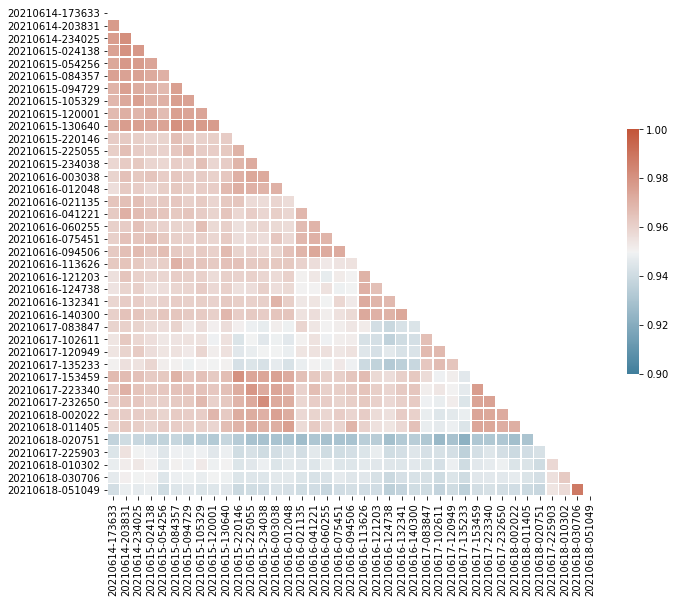

In [59]:
corr = oofs[pred_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0.9, vmax=1.0, # center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [60]:
oofs.describe()

,target,standard_error,20210614-173633,20210614-203831,20210614-234025,20210615-024138,20210615-054256,20210615-084357,20210615-094729,20210615-105329,...,20210617-153459,20210617-223340,20210617-232650,20210618-002022,20210618-011405,20210618-020751,20210617-225903,20210618-010302,20210618-030706,20210618-051049
count,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,...,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000
mean,-0.959319,0.491435,-0.948092,-0.939186,-0.936123,-0.968496,-0.958907,-0.891844,-0.910382,-0.932254,...,-0.947358,-0.934434,-0.897131,-0.929332,-0.948334,-0.965103,-0.966651,-0.952552,-0.954686,-0.938379
std,1.033579,0.034818,0.912312,0.889185,0.913707,0.930968,0.905059,0.907261,0.927470,0.911461,...,0.933233,0.952958,0.903592,0.923929,0.907960,0.885307,0.892586,0.917085,0.913182,0.906118
min,-3.676268,0.000000,-3.560785,-3.392829,-3.732013,-3.534283,-3.483280,-3.612729,-3.607502,-3.599687,...,-3.552056,-3.462885,-3.441969,-3.453259,-3.474692,-3.468793,-3.266053,-3.609784,-3.436764,-3.436764
25%,-1.690320,0.468543,-1.613250,-1.570393,-1.616401,-1.659845,-1.625832,-1.550567,-1.581456,-1.592230,...,-1.626049,-1.610281,-1.536891,-1.608234,-1.609384,-1.633464,-1.638568,-1.657498,-1.655892,-1.628204
50%,-0.912190,0.484721,-0.900925,-0.891787,-0.904669,-0.926716,-0.913854,-0.845645,-0.853657,-0.858941,...,-0.892049,-0.869432,-0.822918,-0.868418,-0.883146,-0.921755,-0.902348,-0.905550,-0.902907,-0.880784
75%,-0.202540,0.506268,-0.242909,-0.258008,-0.232878,-0.260776,-0.254002,-0.191775,-0.206128,-0.229850,...,-0.231044,-0.189920,-0.194258,-0.216674,-0.248127,-0.268526,-0.277555,-0.232635,-0.229983,-0.229795
max,1.711390,0.649671,1.249225,1.150385,1.232993,1.288711,1.167053,1.241939,1.432130,1.164523,...,1.094046,1.226784,1.264218,1.200630,1.207516,1.079625,1.058555,1.307559,1.148694,1.148694


In [61]:
scores = cross_val_score(
#     LinearRegression(),
    Ridge(alpha=100),
#     BaggingRegressor(n_estimators=100),
    oofs[pred_cols],
    oofs["target"],
    scoring="neg_mean_squared_error",
#     cv=LeaveOneOut(),
    n_jobs=-1,
)
print(f"Best score: {np.sqrt(np.mean(-scores)):0.5f}")

Best score: 0.45429


In [62]:
# # reg = LassoCV(max_iter=5000, cv=LeaveOneOut(), n_jobs=-1)  # 0.45689
# reg = ElasticNetCV(l1_ratio=[0.01, 0.05, .1, .5, .7, .9, .95, .99, 1], max_iter=5000, n_jobs=-1, tol=1e-5)  # 0.45619

# reg.fit(oofs[pred_cols], oofs["target"])
# # print(f"Best score: {np.sqrt(reg.mse_path_[-1].mean()):0.5f}")
# print(reg.l1_ratio_)

# np.sqrt(reg.mse_path_[1, -1].mean())

# Brute force model selection

In [63]:
# def powerset(iterable):
#     "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
#     s = list(iterable)  # allows duplicate elements
#     return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

# subsets = list(powerset(pred_cols))
# len(subsets)

In [64]:
# best_score = 10
# best_cols = None

# for s in tqdm(subsets[1:]):
#     reg = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000))
#     reg.fit(oofs[list(s)], oofs["target"])
#     score = np.sqrt(-reg.best_score_)
    
#     if score < best_score:
#         best_score = score
#         best_cols = list(s)
        
# print(f"Best score: {best_score:0.5f}")
# print("Best cols", best_cols)

In [65]:
# ['model_1', 'model_2', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', 'model_9', 'model_11', 'model_13', 'model_16']

# Hill climbing

In [66]:
def get_score(X, y):
    reg = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000))
    reg.fit(X, y)
    return np.sqrt(-reg.best_score_)

In [67]:
candidates = model_folders.copy()

best_score = np.inf
selection = []
# tol = 0.00001
tol = 0
y = oofs["target"]

# Find best initial model
initial_scores = [np.sqrt(mean_squared_error(oofs[c], oofs["target"])) for c in candidates]
idx = np.argmin(initial_scores)
best_score = initial_scores[idx]
selection.append(candidates[idx])
print(f"Initial {candidates[idx]}. Score {best_score:0.5f}")
del candidates[idx]


while True:
    scores = [get_score(oofs[selection + [c]], y) for c in candidates]
    idx = np.argmin(scores)
    if scores[idx] < best_score - tol:
        best_score = scores[idx]
        selection.append(candidates[idx])
        print(f"Added {candidates[idx]}. New best score {best_score:0.5f}")
        del candidates[idx]
    else:
        break
        
print(len(selection), "models selected")
        
selection

Initial 20210614-234025. Score 0.48016
Added 20210616-041221. New best score 0.46563
Added 20210617-135233. New best score 0.45928
Added 20210615-225055. New best score 0.45714
Added 20210618-030706. New best score 0.45595
Added 20210614-173633. New best score 0.45498
Added 20210616-060255. New best score 0.45436
Added 20210617-120949. New best score 0.45406
Added 20210616-132341. New best score 0.45378
Added 20210615-094729. New best score 0.45362
Added 20210615-105329. New best score 0.45349
Added 20210615-234038. New best score 0.45336
Added 20210617-102611. New best score 0.45329
Added 20210616-121203. New best score 0.45322
Added 20210616-003038. New best score 0.45311
Added 20210618-020751. New best score 0.45307
Added 20210615-220146. New best score 0.45305
17 models selected


['20210614-234025',
 '20210616-041221',
 '20210617-135233',
 '20210615-225055',
 '20210618-030706',
 '20210614-173633',
 '20210616-060255',
 '20210617-120949',
 '20210616-132341',
 '20210615-094729',
 '20210615-105329',
 '20210615-234038',
 '20210617-102611',
 '20210616-121203',
 '20210616-003038',
 '20210618-020751',
 '20210615-220146']

In [41]:
model_folders = [
    # cherubic-nifty-serval - deberta-large
#     "20210614-173633",
#     "20210614-203831",
#     "20210614-234025",
#     "20210615-024138",
#     "20210615-054256",
    # scrupulous-mink-of-amplitude - deberta-base
#     "20210615-084357",
#     "20210615-094729",
#     "20210615-105329",
#     "20210615-120001",
#     "20210615-130640",
    # notorious-sticky-gibbon - roberta-base (with hidden)
#     "20210615-220146",
#     "20210615-225055",
#     "20210615-234038",
#     "20210616-003038",
#     "20210616-012048",
    # fortunate-cherry-mandrill - roberta-large
#     "20210616-021135",
#     "20210616-041221",
#     "20210616-060255",
#     "20210616-075451",
#     "20210616-094506",
    # mottled-certain-caracal - distilroberta-base
#     "20210616-113626",
#     "20210616-121203",
#     "20210616-124738",
#     "20210616-132341",
#     "20210616-140300",
    # aspiring-classic-pegasus - funnel
#     "20210617-083847", 
#     "20210617-102611", 
#     "20210617-120949", 
#     "20210617-135233", 
#     "20210617-153459", 
]